# Likelihood free inference example

Philipp Eller (philipp.eller@tum.de), January 2020

This notebook illisutrates the method of likelihood free inference using a simple toy example. A known distribution is used to sample a number $N$ of parameters $\theta$. For each sampled paranmeter value we then produce a possible outcome $x$ using another known distribution.

This will result in samples ("Set A") distributed according to $p(x|\theta)p(\theta) = p(x,\theta)$.

A second set ("Set B") will be created by breakig the correlation between $x$ and $\theta$ of the first set (by random shuffling), resulting in samples distributed according to $p(x)p(\theta)$.

Training a classifier $d$ on labels 1 for Set A and 0 for Set B minimizing the binary cross entropy will result in the following:
$\frac{d}{1-d} = \frac{p(x|\theta)}{p(x)}$
Which is the likelihood to evidence ratio. Since for a fixed observation $x$ the evidence is a contsant, this is also directly proportional to the likelihood.


The method is based on the following works:
* arXiv:1805.12244 “Mining gold from implicit models to improve
likelihood-free inference” Johann Brehmer, Gilles Louppe, Juan
Pavez, Kyle Cranm
* arXiv:1903.04057 “Likelihood-free MCMC with Amortized
Approximate Likelihood Ratios” Joeri Hermans, Volodimir Begy,
Gilles Louppe

In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from scipy import stats

%load_ext autoreload
%autoreload 2

from sklearn.model_selection import train_test_split

In [2]:
plt.rcParams['figure.figsize'] = [12., 8.]
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14 
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 14

In [3]:
# Choose a number of samples (50% training, 50% validation)
N = 2 * 100000

# sample thetas
theta_kwargs = {'scale':3, 'loc':5}
theta_dist = stats.norm
thetas = theta_dist.rvs(size=N, **theta_kwargs)

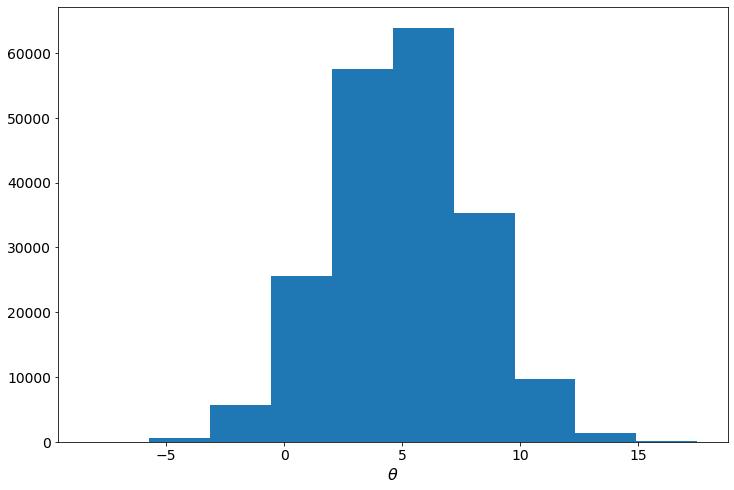

In [4]:
plt.hist(thetas)
plt.gca().set_xlabel(r'$\theta$');

In [5]:
# sample x
x_kwargs = {'scale': 0.1}
x_dist = stats.norm
xs = x_dist.rvs(loc=thetas, **x_kwargs)

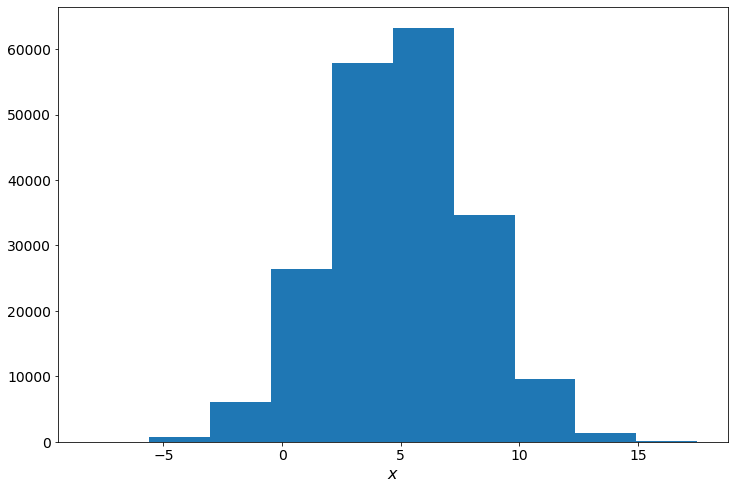

In [6]:
plt.hist(xs)
plt.gca().set_xlabel(r'$x$');

In [7]:
# Split into training and testing samples
x_train, x_test, theta_train, theta_test = train_test_split(xs, thetas, test_size=0.5)

In [8]:
# Creat a very simple NN

activation = 'relu'

inputs = tf.keras.Input(shape=(2,))

h = tf.keras.layers.Dense(16, activation=activation)(inputs)
h = tf.keras.layers.Dense(32, activation=activation)(h)
h = tf.keras.layers.Dense(64, activation=activation)(h)
h = tf.keras.layers.Dense(32, activation=activation)(h)
h = tf.keras.layers.Dense(16, activation=activation)(h)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(h)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()

loss_history = []
val_loss_history = []

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 16)                48        
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17    

In [9]:
# Compile the model
optimizer = tf.keras.optimizers.Adam(0.001)
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(loss=loss, optimizer=optimizer)

Epoch 1
Train on 200000 samples, validate on 200000 samples
200000/200000 [==============================] - 1s 6us/sample - loss: 0.4045 - val_loss: 0.1543
Epoch 2
Train on 200000 samples, validate on 200000 samples
200000/200000 [==============================] - 0s 2us/sample - loss: 0.1162 - val_loss: 0.1097
Epoch 3
Train on 200000 samples, validate on 200000 samples
200000/200000 [==============================] - 0s 2us/sample - loss: 0.1008 - val_loss: 0.0973
Epoch 4
Train on 200000 samples, validate on 200000 samples
200000/200000 [==============================] - 0s 2us/sample - loss: 0.1004 - val_loss: 0.0990
Epoch 5
Train on 200000 samples, validate on 200000 samples
200000/200000 [==============================] - 0s 2us/sample - loss: 0.0991 - val_loss: 0.1015
Epoch 6
Train on 200000 samples, validate on 200000 samples
200000/200000 [==============================] - 0s 1us/sample - loss: 0.0984 - val_loss: 0.1021
Epoch 7
Train on 200000 samples, validate on 200000 sample

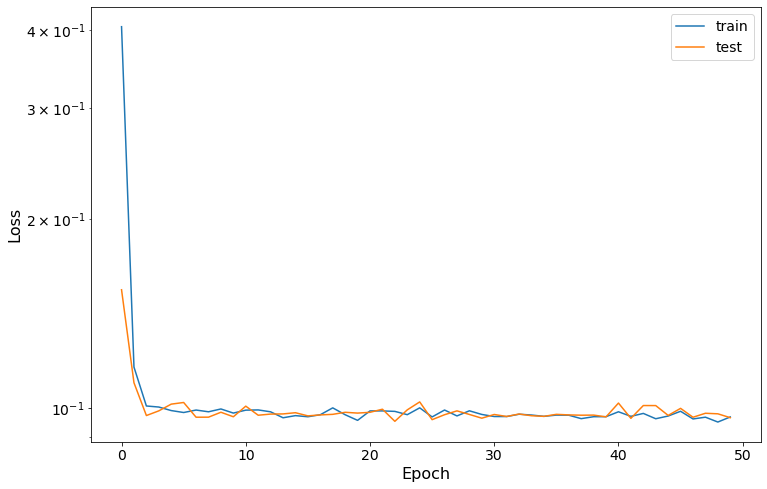

In [10]:
# Train the model
for i in range(50):
    
    # re-shuffle inputs after every Epoch
    X_input_train = np.stack([np.concatenate([x_train, x_train]), np.concatenate([theta_train, np.random.permutation(theta_train)])], axis=1)
    y_input_train = np.concatenate([np.ones_like(x_train), np.zeros_like(x_train)])

    X_input_test = np.stack([np.concatenate([x_test, x_test]), np.concatenate([theta_test, np.random.permutation(theta_test)])], axis=1)
    y_input_test = np.concatenate([np.ones_like(x_test), np.zeros_like(x_test)])

    print('Epoch %i'%(len(loss_history)+1))
    model.fit(X_input_train, y_input_train, batch_size=2048, epochs=1, validation_data=(X_input_test, y_input_test), )
    
    loss_history.append(model.history.history['loss'])
    val_loss_history.append(model.history.history['val_loss'])

# Plot training
fig, ax = plt.subplots(1, 1, figsize=(12,8))
ax.plot(np.concatenate(loss_history), label='train')
ax.plot(np.concatenate(val_loss_history), label='test')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_yscale('log')
ax.legend()

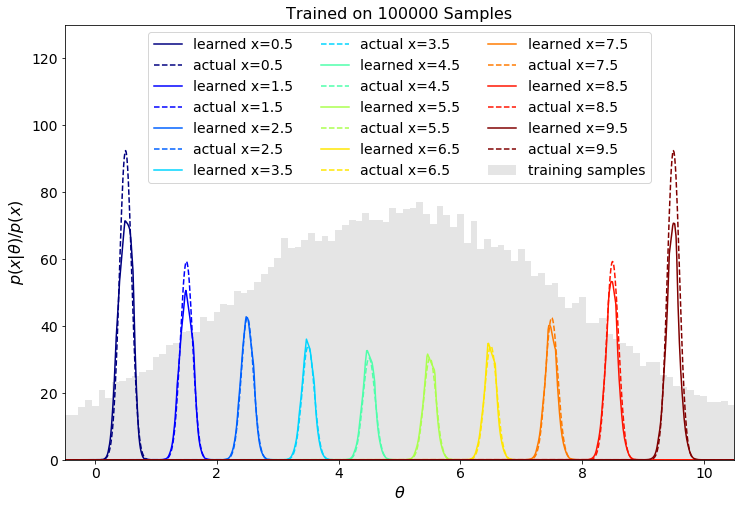

In [11]:
# Compare prediciton vs. truth

fig, ax = plt.subplots(1, 1, figsize=(12,8))

# plotting values
theta_plot = np.linspace(-0.5,10.5,1001)
n=10
colors = plt.cm.jet(np.linspace(0,1,n))

for i, k in enumerate(np.linspace(0.5,9.5,n)):
    
    # We do some really dumb integration by hand to get the truth
    n_int_steps = 1000
    theta_min = -20
    theta_max = 30
    int_thetas = np.linspace(theta_min, theta_max, n_int_steps)
    p_thetas = theta_dist.pdf(int_thetas, **theta_kwargs)    
    evidence = np.sum(x_dist.pdf(k, int_thetas, **x_kwargs) * p_thetas) * (theta_max - theta_min) / n_int_steps        # p(x)
    truth = x_dist.pdf(k, theta_plot,  **x_kwargs) / evidence

    # generate input to NN
    nn_input = np.stack([np.ones_like(theta_plot) * k, theta_plot], axis=1)

    prediction = model.predict(nn_input)
    prediction /= 1 - prediction

    ax.plot(theta_plot, prediction , label='learned x=%s'%k, color=colors[i])
    ax.plot(theta_plot, truth, label='actual x=%s'%k, color=colors[i], ls='--')

    
plt.gca().set_xlabel(r'$\theta$')
plt.gca().set_ylabel(r'$p(x|\theta)/p(x)$')

plt.hist(theta_train, weights=np.ones_like(theta_train) * 5000/len(theta_train), bins=np.linspace(theta_plot[0],theta_plot[-1],100), color='gray', alpha=0.2, label='training samples')

ax.set_xlim(theta_plot[0],theta_plot[-1])

ax.set_title('Trained on %i Samples'%len(theta_train))

ax.set_ylim(0, 130)

plt.legend(ncol=3, loc='upper center')

plt.savefig('likelihood_test_%i_samples.png'%len(theta_train))